In [ ]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, LeakyReLU, Dense
from sklearn.model_selection import train_test_split
import plotly.express as px

In [ ]:
params = {
    'latitude': 22.572645,
    'longitude' :88.363892,
    'start_date' : '2023-06-01',
    'end_date': '2023-07-30',
    'hourly': {'temperature_2m','relativehumidity_2m','windspeed_10m'}
}
result = requests.get("https://api.open-meteo.com/v1/forecast",params = params).json()
print(result)

{'latitude': 22.625, 'longitude': 88.375, 'generationtime_ms': 69.36192512512207, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 12.0, 'hourly_units': {'time': 'iso8601', 'temperature_2m': '°C', 'relativehumidity_2m': '%', 'windspeed_10m': 'km/h'}, 'hourly': {'time': ['2023-06-01T00:00', '2023-06-01T01:00', '2023-06-01T02:00', '2023-06-01T03:00', '2023-06-01T04:00', '2023-06-01T05:00', '2023-06-01T06:00', '2023-06-01T07:00', '2023-06-01T08:00', '2023-06-01T09:00', '2023-06-01T10:00', '2023-06-01T11:00', '2023-06-01T12:00', '2023-06-01T13:00', '2023-06-01T14:00', '2023-06-01T15:00', '2023-06-01T16:00', '2023-06-01T17:00', '2023-06-01T18:00', '2023-06-01T19:00', '2023-06-01T20:00', '2023-06-01T21:00', '2023-06-01T22:00', '2023-06-01T23:00', '2023-06-02T00:00', '2023-06-02T01:00', '2023-06-02T02:00', '2023-06-02T03:00', '2023-06-02T04:00', '2023-06-02T05:00', '2023-06-02T06:00', '2023-06-02T07:00', '2023-06-02T08:00', '2023-06-02T09:00', '2023-06-

In [ ]:
df = pd.DataFrame(result['hourly'])
df.head()

,time,temperature_2m,relativehumidity_2m,windspeed_10m
0,2023-06-01T00:00,29.2,90,3.7
1,2023-06-01T01:00,30.1,86,5.4
2,2023-06-01T02:00,31.5,80,6.2
3,2023-06-01T03:00,33.0,74,7.9
4,2023-06-01T04:00,34.7,66,7.1


In [ ]:
c = df["relativehumidity_2m"]
df["relativehumidity_2m"] = df["windspeed_10m"]
df["windspeed_10m"] = c

In [ ]:
df.rename({"relativehumidity_2m" : "windspeed_10m", "windspeed_10m" : "relativehumidity_2m"},axis =1, inplace = True)

In [ ]:
df.head()

,time,temperature_2m,windspeed_10m,relativehumidity_2m
0,2023-06-01T00:00,29.2,3.7,90
1,2023-06-01T01:00,30.1,5.4,86
2,2023-06-01T02:00,31.5,6.2,80
3,2023-06-01T03:00,33.0,7.9,74
4,2023-06-01T04:00,34.7,7.1,66


array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

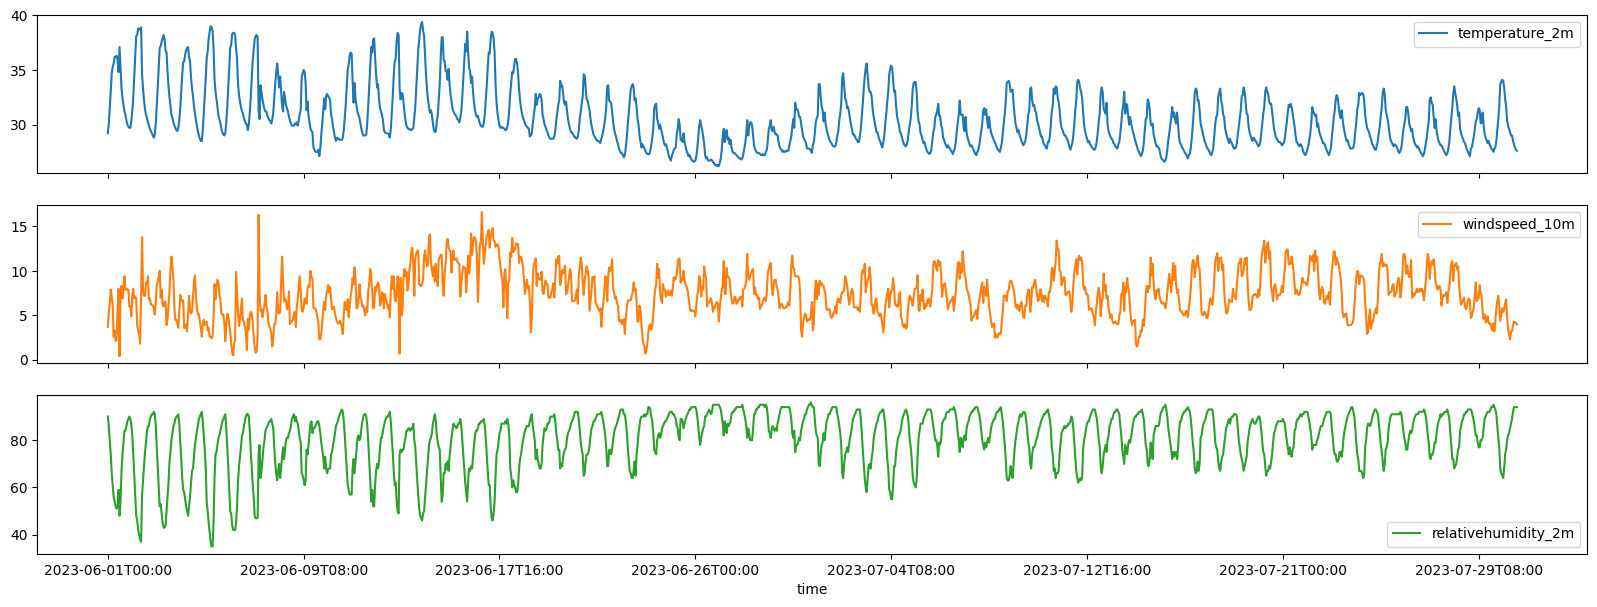

In [ ]:
df.set_index("time", inplace = True)
df.plot(figsize = (20,7), subplots = True)

In [ ]:
fig = px.line(df, x=df.index, y='relativehumidity_2m', title='Humidity')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [ ]:
scaler = MinMaxScaler()
data = scaler.fit_transform(df)

In [ ]:
x_train,x_test, y_train,y_test = train_test_split(data,data[:,2],train_size = 0.8,shuffle = False)

In [ ]:
x_train.shape[0]

1152

In [ ]:
x_test.shape[0]

288

In [ ]:
win_length = 10
batch_size = 5
num_features = 3
train_generator = TimeseriesGenerator(x_train,y_train, win_length, batch_size = batch_size)
test_generator = TimeseriesGenerator(x_test,y_test, win_length, batch_size = batch_size)

In [ ]:
model = Sequential()
model.add(LSTM(15, input_shape = (win_length, num_features), return_sequences = True))
model.add(LeakyReLU(alpha = 0.2))
model.add(Dropout(0.5))
model.add(LSTM(15, return_sequences = True))
model.add(LeakyReLU(alpha = 0.2))
model.add(LSTM(15, return_sequences = False))
model.add(LeakyReLU(alpha = 0.2))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", metrics = "mean_squared_error")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 24)            2688      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10, 24)            0         
                                                                 
 dropout (Dropout)           (None, 10, 24)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 24)            4704      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 10, 24)            0         
                                                                 
 lstm_2 (LSTM)               (None, 24)                4704      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 24)                0

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 15)

In [ ]:
history = model.fit(train_generator,epochs = 100,validation_data = test_generator,shuffle = False, callbacks = [callback])

Epoch 1/100
229/229 [==============================] - 11s 24ms/step - loss: 0.0516 - mean_squared_error: 0.0516 - val_loss: 0.0188 - val_mean_squared_error: 0.0188
Epoch 2/100
229/229 [==============================] - 3s 15ms/step - loss: 0.0330 - mean_squared_error: 0.0330 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 3/100
229/229 [==============================] - 4s 20ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 4/100
229/229 [==============================] - 3s 15ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 5/100
229/229 [==============================] - 3s 15ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 6/100
229/229 [==============================] - 4s 16ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 7/100
229

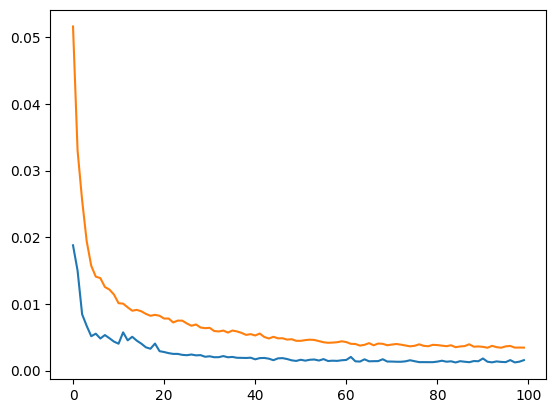

In [ ]:
plt.plot(history.history["val_loss"],label=  "val_loss")
plt.plot(history.history["loss"],label = "loss")

In [ ]:
model.save("model_humidity.keras")

In [ ]:
prediction  = model.predict_generator(test_generator)

<ipython-input-33-7963bfab3b74>:1: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



In [ ]:
test_data = pd.DataFrame(scaler.inverse_transform(pd.concat([pd.DataFrame(x_test[:,:2]),pd.DataFrame(y_test)],axis = 1)))
test_data

,0,1,2
0,27.9,6.8,91.0
1,28.3,8.4,90.0
2,29.1,9.8,85.0
3,29.8,10.9,80.0
4,30.6,10.9,77.0
...,...,...,...
283,28.5,3.8,92.0
284,28.2,4.3,94.0
285,27.9,4.1,94.0
286,27.7,4.2,94.0


In [ ]:
time = df.index
pred_time = time[1152:]

In [ ]:
pred_df = pd.concat([pd.DataFrame(x_test[:,:2][win_length:]),pd.DataFrame(prediction[:,-1])], axis = 1)
pred_df =  pd.DataFrame(scaler.inverse_transform(pred_df))
pred_df.iloc[:][2]

0      69.677168
1      73.298650
2      77.152261
3      80.755225
4      84.028269
         ...    
273    89.679809
274    90.816183
275    91.857976
276    92.819413
277    92.808709
Name: 2, Length: 278, dtype: float64

In [ ]:
df_pred = pd.DataFrame(pred_df.iloc[:][2])
df_test = pd.DataFrame(test_data[win_length:][2])
df_pred.index = pred_time[win_length:]
df_test.index = pred_time[win_length:]

<Axes: xlabel='time'>

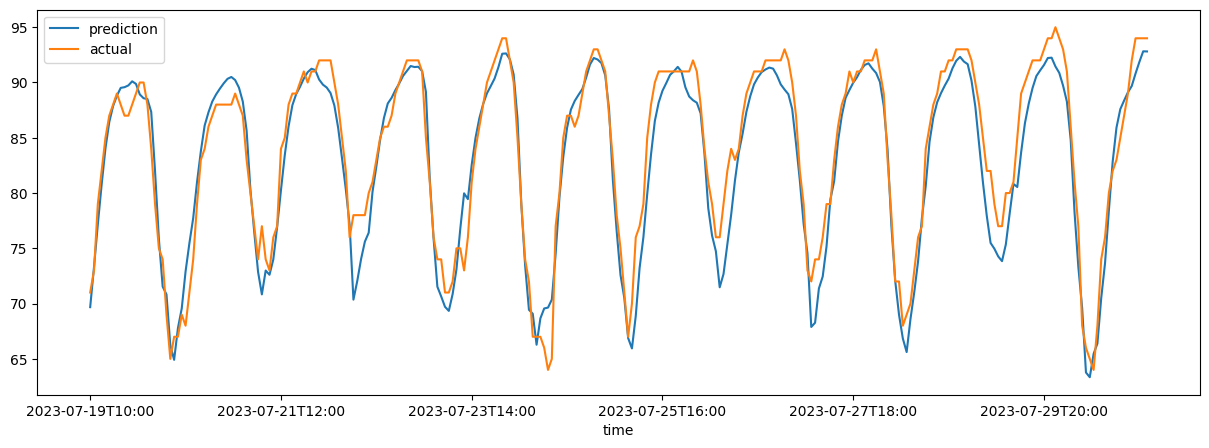

In [ ]:
df_compare = pd.concat([df_pred,df_test], axis = 1)
df_compare.columns = ["prediction","actual"]
df_compare.plot(figsize = (15,5))